# Gene expression (count) modeling from single-Cell RNA Sequencing Data
UMI counts in Single-Cell RNA Sequencing Data usually exhibiy Zero-Inflated Negative Binomial or Negatuve Binomial Distribution. An examploe of histogram of one such gene count for several cell-samples is shown below:
![image.png](figures/histogram_gene_count.png)

*Negative Binomial pdf*:

Negative binomial in terms of successes $x$ and failures $r$ can be written as:

$$
f_{NB}(x, r, p) = \binom{x + r - 1}{r} p^x (1-p)^r
$$
where $p$ is the probability of success. 

$$
\binom{x + r - 1}{r}
$$ 
can be written as 
$$ \binom{x + r - 1}{r} = \frac{\Gamma(x+r)}{x! \Gamma(r)}$$

Mean of the negative binomial, $\mu = \frac{pr}{1-p}$

In terms of mean and gamma function:
$$
f_{NB}(x, r, p) = \cfrac{\Gamma(r+x)}{x! \Gamma(r)} \cdot \bigg( \cfrac{r}{r + \mu}\bigg)^r \cdot \bigg(\cfrac{\mu}{\mu + r}\bigg)^x
$$

Usuall, $r$ is denoted as $\phi $ and called the dispersion parameter.

In terms of mean and dispersion parameter:

$$
f_{NB}  = f(x|\mu, \phi) = \cfrac{\Gamma(x+\phi)}{\Gamma(\phi)\cdot x!} \cdot \cfrac{\mu^x \phi^\phi}{(\mu + \phi)^{x+\phi}}
= \cfrac{(x+\phi - 1)!}{(\phi - 1)!\cdot x!} \cdot \cfrac{\mu^x \phi^\phi}{(\mu + \phi)^{x+\phi}}
$$

where $\mu$ is the expectation of the negative binomial distribition and $\phi$ is the dispersion parameter, shape parameter or clustering coefficient. The variance $s$ is given by 

$$s = \cfrac{\phi \mu + \mu^2}{\phi}$$.
The above formula can be used to calculate dispersion parameter empirically as follows:

$$
\phi = \cfrac{\mu^2}{s - \mu }
$$

$p$, the probability of successes can be written as:

$$
p = \cfrac{\mu}{\phi + \mu}
$$

*Zero-inflated Negative Binomial pdf, modeling the counts of j-the gene*:
$$
f_{ZINB}(X_j = x) = \begin{cases} \pi_j + (1 - \pi_j)f_{NB}(0)\quad \text{if }~~~ x= 0\\
(1 - \pi_j)f_{NB}(x)\quad \text{if }~~~ x \in \mathbb{N}
\end{cases}
$$

Then, 

$$
L(\mu, \phi, \pi|\textbf{x})  = L(\theta|x_1, x_2, \cdots, x_n)  = \prod_{i=1}^n f_{ZINB}(x_i | \mu, \phi, \pi) 
$$


Then, we can determine $\boldsymbol{\theta} = (\mu, \phi, \pi)$ using as follows:

$$
\hat{\boldsymbol{\theta} } = \text{arg} \max_{\boldsymbol{\theta} \in \Theta}L(\mu, \phi, \pi|\textbf{x}) 
$$

$$
= \text{arg} \max_{\boldsymbol{\theta} \in \Theta}\prod_{i=1}^n f_{ZINB}(x_i | \mu, \phi, \pi)
$$


In practical, we calculate $\boldsymbol{\theta}$ using log likelihood.

$$
\hat{\boldsymbol{\theta} } = \text{arg} \max_{\boldsymbol{\theta} \in \Theta}\log L(\mu, \phi, \pi|\textbf{x}) 
$$

$$
\hat{\boldsymbol{\theta} } = \text{arg} \max_{\boldsymbol{\theta} \in \Theta}\log \prod_{i=1}^n f_{ZINB}(x_i | \mu, \phi, \pi)
$$

$$
\hat{\boldsymbol{\theta} } = \text{arg} \max_{\boldsymbol{\theta} \in \Theta} \sum_{i=1}^n \log f_{ZINB}(x_i | \mu, \phi, \pi)
$$

In other worlds, we want to find out what values of $\boldsymbol{\theta}$ maximizes $L(\boldsymbol(\theta)|\textbf{x})$. In other words, find the global maxima of $L(\boldsymbol(\theta)|\textbf{x})$ or finding the global maxima of  $\log L(\boldsymbol(\theta)|\textbf{x})$. Assuming $L(\boldsymbol(\theta)|\textbf{x})$ is differentiable, we want to solve:

$$
\cfrac{\partial }{\partial \theta_j}\log L(\boldsymbol(\theta)|\textbf{x})  = 0 , \quad \forall j = 1, \cdots, k
$$

However, most libraries, such as Tensorfow perform minimization rather than maximization. Hence, we minimize the negative of log-likelihood function. In that case, 

$$
\hat{\boldsymbol{\theta} } = \text{arg} \min_{\boldsymbol{\theta} \in \Theta} -\sum_{i=1}^n \log f_{ZINB}(x_i | \mu, \phi, \pi)
$$


## Import Important Packages

In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (24, 18)
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 18})
import tensorflow_probability as tfp
from tensorflow_probability.python import distributions as tfd

**Tensorflow doesn't have $\Gamma(x)$ function. However, it has `tf.math.lgamma` function that computes the log of the absolute value of $\Gamma(x)$ element-wise. Hence, the exponent will give you the raw $\Gamma(x)$ value:**

In [56]:
@tf.function
def tfgamma(z):
    g = tf.exp(tf.math.lgamma(z))
    return g

## Method of Moment-Estimator

tf.Tensor(1.3973354, shape=(), dtype=float32)
tf.Tensor(1.6983671, shape=(), dtype=float32)
tf.Tensor(6.4861813, shape=(), dtype=float32)
tf.Tensor(0.17724772, shape=(), dtype=float32)


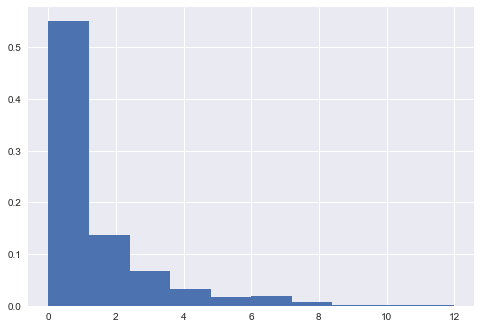

In [57]:
# We will read a column of Lukassen Data
X = pd.read_csv('UMICount_1.csv')
plt.hist(X.values, bins=10,  density = True)
X = tf.constant(X.values, dtype=tf.float32)

# Calculate, mean and variance and hence dispersion parameter
# and probability of successes using method of moment estimator
empirical_mean = tf.reduce_mean(X)
empirical_variance = tf.math.reduce_std(X)
print(empirical_mean)
print(empirical_variance)

empirical_dispersion = (empirical_mean**2)/(empirical_variance - empirical_mean)
print(empirical_dispersion)

empirical_probability = empirical_mean/(empirical_mean + empirical_dispersion)
print(empirical_probability)

negbinom = tfd.NegativeBinomial(
        total_count=tf.math.round(empirical_dispersion), probs=empirical_probability, validate_args=True)

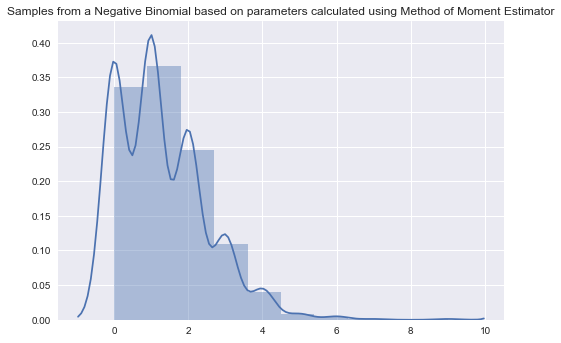

In [80]:
import seaborn as sns
# Plot 1000 samples from a negative biniomal
samples = negbinom.sample(1000)
sns.distplot(samples, bins=10)
plt.title("Samples from a Negative Binomial based on parameters calculated using Method of Moment Estimator")
plt.show()

## Likelihood Function for Negative Binomial Function
Let's write a function to encode Likelihood Function for Negative Binomial Function.

In [42]:
@tf.function
def NB(x, mu, phi):
    numerator = tfgamma(x + phi)*(mu**x)*(phi**phi)
    denominator = tfgamma(phi)*tfgamma(x+1) *((mu + phi)**(x+phi))
    return (numerator/denominator)

@tf.function
def negloglikelihood(mu, phi):
    # mu, phi = tf.split(theta, [1, 1])
    sum = tf.constant([0.0])
    for x in X:
        summand = tf.math.log(NB(x, mu, phi ))
        print("Summand: {}".format(summand))
        sum = sum + summand
    return -1.0*sum

@tf.function
def lminimize():
    sum = tf.constant([0.0])
    for x in X:
        sum = sum + tf.math.log(NB(x, mu, phi ))
    return -1.0*sum

# test the function
mu = tf.Variable(0.3) 
phi = tf.Variable(0.13) 
negloglikelihood(mu, phi).numpy()

Summand: Tensor("Log:0", shape=(1,), dtype=float32)


array([5808.8623], dtype=float32)

Let minimization objective function be $f(\theta) = -\sum_{i=1}^n \log f_{NB}(x_i | \mu, \phi)$ where $\theta = (\mu, \phi)$.

Then, the value of $\theta$ that minimizes $f$ can be written as $$\theta^* = \arg \min_{\theta \in \Theta} f (\theta)$$.

Normally, we use stochastic gradient descent to find the minimizer, with an update rule that looks like as follows:

$$
\theta_{t+1} = \theta_{t}  - \alpha_t \nabla f (\theta_t)
$$

In [43]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1)


In [44]:
#theta = tf.constant([empirical_mean.numpy(), empirical_dispersion.numpy()])
#mu = tf.Variable(empirical_mean.numpy()) 
#phi = tf.Variable(empirical_dispersion.numpy()) 

#opt = tf.keras.optimizers.SGD(learning_rate=0.1)
#for i in range(50):
#    theta = tf.constant([mu.numpy(), phi.numpy()])
#    print ('f: {0}, mu = {1}, phi = {2} '.format(negloglikelihood(theta), theta[0].numpy(), theta[1].numpy()))
#    opt.minimize(lminimize, var_list=[mu, phi])

In [ ]:
# Intiial mu and phi are calculated from method of moments estimators

mu = tf.Variable(empirical_mean.numpy()) 
phi = tf.Variable(empirical_dispersion.numpy())

mu_old = None
phi_old = None
# theta = tf.constant([mu.numpy(), phi.numpy()])
f = []
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
for i in range(50000):
    with tf.GradientTape() as tape:
        y = negloglikelihood(mu, phi)
    grads = tape.gradient(y, [mu, phi])
    processed_grads = [g for g in grads]
    grads_and_vars = zip(processed_grads, [mu, phi])
    f.append(negloglikelihood(mu, phi))
    if mu is not None
        if mu_old - mu < 0.000001 and phi_old - phi < 0.000001:
            break
    print ('f: {0}, mu = {1}, phi = {2} '.format(negloglikelihood(mu, phi), mu.numpy(), phi.numpy()))
    mu_old = mu
    phi_old = phi
    opt.apply_gradients(grads_and_vars)

In [ ]:
#mu = tf.Variable(empirical_mean.numpy()) 
#phi = tf.Variable(empirical_dispersion.numpy())
#for i in range(50):
#    with tf.GradientTape() as tape:
#        y = negloglikelihood(mu, phi)
#    grads = tape.gradient(y, [mu, phi])
#    print("grads: {}".format(grads))
#    print ('f: {0}, mu = {1}, phi = {2} '.format(negloglikelihood(mu, phi), mu.numpy(), phi.numpy()))
#    mu.assign(mu - 0.00001*grads[0].numpy())
#    phi.assign(phi - 0.00001*grads[1].numpy())

In [50]:

p = mu/(phi + mu)
print(p)
print(tf.math.round(6.486181259155273 ))
print(tf.math.round(phi ))

tf.Tensor(0.47772437, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


In [67]:
negbinom_ML = tfd.NegativeBinomial(
        total_count=tf.math.round(phi), probs=p, validate_args=True)

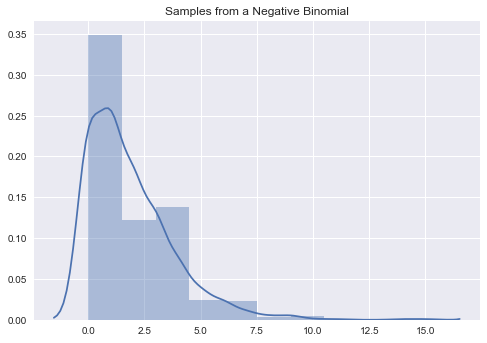

In [68]:
import seaborn as sns
# Plot 1000 samples from a negative biniomal
samples = negbinom_ML.sample(1000)
sns.distplot(samples, bins=10)
plt.title("Samples from a Negative Binomial")
plt.show()